In [1]:
# Code Library/Packages:
from types import ModuleType
import pandas as pd
import numpy as np
import random
import types
import pkg_resources
import gc
import tqdm as tqdm

# Visual Library/Packages:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

# Sklearn Library/Packages:
from sklearn.model_selection import train_test_split

# NLTK Library/Packages:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Transformers Library/Packages:
import transformers
from transformers import BertModel, BertConfig
from transformers import AutoModel, BertTokenizerFast

# Torch Library/Packages:
import torch
from torch import nn, optim, argmax
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchmetrics.functional import accuracy
from torchmetrics.classification import MulticlassAccuracy
from torch.nn import functional as F

# Lightning Library/Packages:
import pytorch_lightning as pl

# Setting of seeds for comparable results for learning models:
SEED_VAL=42
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
torch.cuda.manual_seed(SEED_VAL)

# Set random seed and random seed for all lightning models:
RANDOM_SEED=42
pl.seed_everything(RANDOM_SEED)

# Processing Device(s):
processing_device= "cuda" if torch.cuda.is_available() else "cpu"
torch_aval = torch.cuda.is_available()

def get_imports():

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):            
            name = val.__module__.split(".")[0]

        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }

        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

# Set data paths:
IN=r'D:\download_data\in'
OUT=r'D:\download_data\out'

print("----------------------------------------------------")
print("###               VERSION TYPES                  ###")
print("----------------------------------------------------")
print(f"Versions: ", requirements)
print(f"Device(s) to Utilize: ", processing_device)
print(f"Is Torch Availabke?: ", torch_aval)
print(f"# of Devices Found: ", torch.__version__)
print("----------------------------------------------------")
print(f"If NVIDIA-SMI is not found, then CUDA isn't available on this device:")
!nvidia-smi
gc.collect()
print("----------------------------------------------------")
print(f"Clear Torch Cuda Memory: ", torch.cuda.empty_cache())
print("-----ENVIRONMENT IS COMPLETE & STAGED CORRECTLY-----")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\proto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\proto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\proto\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Global seed set to 42


----------------------------------------------------
###               VERSION TYPES                  ###
----------------------------------------------------
Versions:  [('tqdm', '4.64.1'), ('transformers', '4.25.1'), ('nltk', '3.7'), ('matplotlib', '3.6.2'), ('numpy', '1.23.5'), ('torch', '1.13.0+cu117'), ('pandas', '1.5.2'), ('seaborn', '0.12.1'), ('torchmetrics', '0.11.0')]
Device(s) to Utilize:  cuda
Is Torch Availabke?:  True
# of Devices Found:  1.13.0+cu117
----------------------------------------------------
If NVIDIA-SMI is not found, then CUDA isn't available on this device:
Wed Jan 11 10:52:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage 

In [2]:
pub_health_train = pd.read_csv(IN + r"\PUBHEALTH\train.tsv", sep='\t')
pub_health_test = pd.read_csv(IN + r"\PUBHEALTH\test.tsv", sep='\t')

pub_health_train = pub_health_train[pub_health_train['label'] != 'snopes']
pub_health_train = pub_health_train[['main_text','label']]
pub_health_train = pub_health_train.dropna(subset=['main_text', 'label'])

pub_health_test = pub_health_test[pub_health_test['label'] != 'snopes']
pub_health_test = pub_health_test[['main_text','label']]
pub_health_test = pub_health_test.dropna(subset=['main_text', 'label'])

<AxesSubplot: >

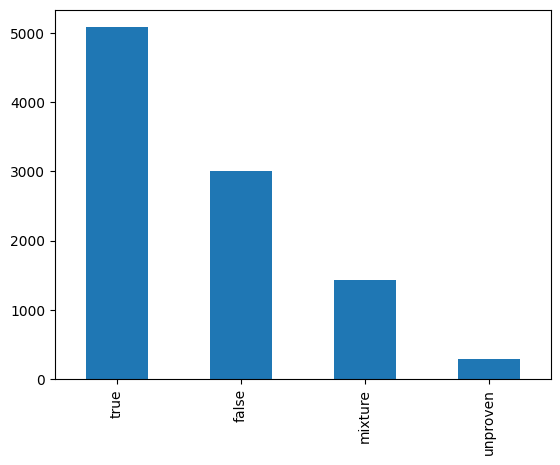

In [3]:
pub_health_train.label.value_counts().plot(kind='bar')

<AxesSubplot: >

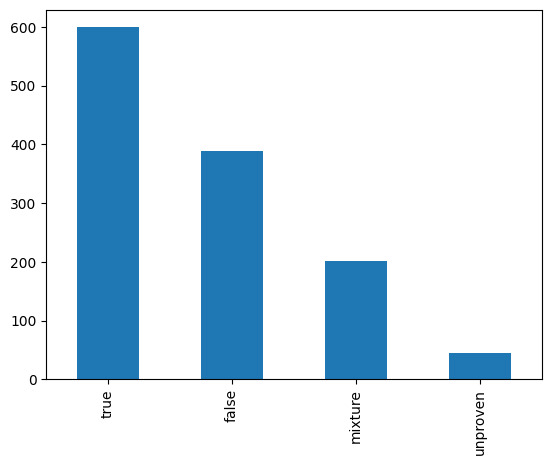

In [4]:
pub_health_test.label.value_counts().plot(kind='bar')

In [5]:
pub_health_train['label'] = pub_health_train['label'].map({"true":0, "false":1, "unproven":2, "mixture":3})
pub_health_test['label'] = pub_health_test['label'].map({"true":0, "false":1, "unproven":2, "mixture":3})

In [6]:
class HealthClaimClassifier(pl.LightningModule):

    def __init__(self, max_seq_len=512, batch_size=128, learning_rate = 0.001):
        super().__init__()
        self.learning_rate = learning_rate
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.loss = nn.CrossEntropyLoss()
        self.pretrain_model  = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.pretrain_model.eval()
        for param in self.pretrain_model.parameters():
            param.requires_grad = False


        self.new_layers = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,4),
            nn.LogSoftmax(dim=1)
        )

    def prepare_data(self):
      tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', return_dict=False, do_lower_case=True)

      tokens_train = tokenizer.batch_encode_plus(
          pub_health_train["main_text"].tolist(),
          max_length = self.max_seq_len,
          padding=True,
          truncation=True,
          return_token_type_ids=False
      )

      tokens_test = tokenizer.batch_encode_plus(
          pub_health_test["main_text"].tolist(),
          max_length = self.max_seq_len,
          padding=True,
          truncation=True,
          return_token_type_ids=False
      )

      self.train_seq = torch.tensor(tokens_train['input_ids'])
      self.train_mask = torch.tensor(tokens_train['attention_mask'])
      self.train_y = torch.tensor(pub_health_train["label"].tolist())

      self.test_seq = torch.tensor(tokens_test['input_ids'])
      self.test_mask = torch.tensor(tokens_test['attention_mask'])
      self.test_y = torch.tensor(pub_health_test["label"].tolist())

    def forward(self, encode_id, mask):
        _, output= self.pretrain_model(encode_id, attention_mask=mask)
        output = self.new_layers(output)
        return output

    def train_dataloader(self):
      train_dataset = TensorDataset(self.train_seq, self.train_mask, self.train_y)
      self.train_dataloader_obj = DataLoader(train_dataset, batch_size=self.batch_size)
      shuffle=True
      num_workers=8
      return self.train_dataloader_obj


    def test_dataloader(self):
      test_dataset = TensorDataset(self.test_seq, self.test_mask, self.test_y)
      self.test_dataloader_obj = DataLoader(test_dataset, batch_size=self.batch_size)
      shuffle=True
      num_workers=8
      return self.test_dataloader_obj

    def training_step(self, batch, batch_idx):
      encode_id, mask, targets = batch
      outputs = self(encode_id, mask) 
      preds = torch.argmax(outputs, dim=1)
      train_accuracy = accuracy(preds, targets, task="multiclass", num_classes=4)
      loss = self.loss(outputs, targets)
      self.log('train_accuracy', train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
      self.log('train_loss', loss, on_step=False, on_epoch=True)
      return {"loss":loss, 'train_accuracy': train_accuracy}

    def test_step(self, batch, batch_idx):
      encode_id, mask, targets = batch
      outputs = self.forward(encode_id, mask)
      preds = torch.argmax(outputs, dim=1)
      test_accuracy = accuracy(preds, targets, task="multiclass", num_classes=4)
      loss = self.loss(outputs, targets)
      return {"test_loss":loss, "test_accuracy":test_accuracy}

    def test_epoch_end(self, outputs):
      test_outs = []
      for test_out in outputs:
          out = test_out['test_accuracy']
          test_outs.append(out)
      total_test_accuracy = torch.stack(test_outs).mean()
      self.log('total_test_accuracy', total_test_accuracy, on_step=False, on_epoch=True)
      return total_test_accuracy

    def configure_optimizers(self):
      params = self.parameters()
      optimizer = optim.Adam(params=params, lr = self.learning_rate)
      return optimizer

In [7]:
model = HealthClaimClassifier()

trainer = pl.Trainer(max_epochs = 10, accelerator = 'gpu', devices = -1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)